In [1]:
from sklearn.preprocessing import StandardScaler
from utils import *

## Get intra-set dataframes

In [2]:
all_transfers_df = pd.read_csv('../data/all_intra_transfers.csv', index_col=[0])
ens_pairs = pd.read_csv('../data/ens_pairs.csv', index_col=[0])

# Check zero-value transfers (Mistakes or Tests) -> doesn't make a large difference for the resulting graph (nodes: 51566, edges: 249302)
# zero_transfers = all_transfers_df[all_transfers_df['value']==0.0]
# zero_transfers = zero_transfers[zero_transfers['from']!= zero_transfers['to']]
# all_transfers_df_cleaned = all_transfers_df[all_transfers_df['value']!=0.0]
# all_transfers_df_cleaned

/Users/dthuerkauf/Desktop/Crypto/masterseminar/python/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3460: DtypeWarning: Columns (7,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Prepare network graph

In [3]:
## Create network graph
G = nx.from_pandas_edgelist(all_transfers_df, 'from', 'to', create_using=nx.MultiDiGraph())
G = clean_graph(G)

# Get the largest connected component (assuming graph is undirected)
largest_cc = max(nx.connected_components(G), key=len)
G_cc = G.subgraph(largest_cc)

# Recode the graph's nodes, node_map maps from address to index
G_cc, node_map = recode_graph(G_cc)

# Create reverse map (from indices to addresses)
idx_map = dict(zip(node_map.values(),node_map.keys()))
ordered_addresses = [idx_map[idx] for idx in range(len(node_map))]

print(f'Nodes: {len(G_cc.nodes())}\nEdges: {len(G_cc.edges())}')

Nodes: 51566
Edges: 249302


### Run models and store the embeddings as a dataframe

In [32]:
# Diff2Vec
diff2vec = Diff2Vec(diffusion_number=10, diffusion_cover=40, dimensions=128, window_size=5, learning_rate=0.025)
embeddings_d2v, emb_d2v_df = fit_model(G_cc, diff2vec, ordered_addresses)
#emb_d2v_df.to_csv('../data/embeddings/diff2vec.csv')

In [ ]:
iterations = 5

rank_arr = []

for i in range(iterations):
    diff2vec = Diff2Vec(diffusion_number=10, diffusion_cover=40, dimensions=128, window_size=5, learning_rate=0.025)
    embeddings_d2v, emb_d2v_df = fit_model(G_cc, diff2vec, ordered_addresses)
    faiss_index_d2v = DistCalculation(embeddings_d2v, node_map)

    ranks = []
    for _, row in ens_pairs.iterrows():
        rank, _ = faiss_index_d2v.foo(row['addr1'], row['addr2'])
        ranks.append(rank)

    # Add the ranks to the array
    rank_arr.append(ranks)

rank_arr = np.array(rank_arr)
# Convert None values to np.nan
rank_arr = [[np.nan if val is None else val for val in sublist] for sublist in rank_arr]
average_rank = np.nanmean(rank_arr, axis=0)
average_rank

In [38]:
# Role2Vec
role2vec = Role2Vec(walk_number=10, walk_length=40, dimensions=128, window_size=5, learning_rate=0.025, epochs=5)
embeddings_r2v, emb_r2v_df = fit_model(G_cc, role2vec, ordered_addresses)
emb_r2v_df.to_csv('../data/embeddings/role2vec.csv')

In [39]:
# DeepWalk
deepWalk = DeepWalk(walk_number=10, walk_length=40, dimensions=128, window_size=5, learning_rate=0.025, epochs=5)
embeddings_deepWalk, emb_deepWalk_df = fit_model(G_cc, deepWalk, ordered_addresses)
emb_deepWalk_df.to_csv('../data/embeddings/deepWalk.csv')

### Initialize distance calculation classes

In [5]:
#Diff2Vec
emb_d2v_df = pd.read_csv('../data/embeddings/diff2vec.csv', index_col='address')
embeddings_d2v = emb_d2v_df.values
faiss_index_d2v = DistCalculation(embeddings_d2v, node_map)

#Role2Vec
emb_r2v_df = pd.read_csv('../data/embeddings/role2vec.csv', index_col='address')
embeddings_r2v = emb_r2v_df.values
faiss_index_r2v = DistCalculation(embeddings_r2v, node_map)

#Deepwalk
emb_dw_df = pd.read_csv('../data/embeddings/deepWalk.csv', index_col='address')
embeddings_dw = emb_dw_df.values
faiss_index_deepWalk = DistCalculation(embeddings_dw, node_map)

# Evaluation using ENS as ground-truth

In [6]:
d2v_ens = ens_pairs
d2v_ens['rank'], d2v_ens['distance'] = zip(*d2v_ens.apply(lambda row: faiss_index_d2v.foo(row['addr1'], row['addr2']), axis=1))

print("Diff2Vec")
print(f"Median Rank: {d2v_ens['rank'].median()}\nMean Rank: {d2v_ens['rank'].mean()}")
print(f"Median Distance: {d2v_ens['distance'].median()}\nMean Distance: {d2v_ens['distance'].mean()}")
d2v_ens

Diff2Vec
Median Rank: 5.0
Mean Rank: 41.945945945945944
Median Distance: 0.9478198885917664
Mean Distance: 0.9407197269233497


addr1  \
ens_name                                                           
anisofim.eth          0x85e5472752a6f00775faca4d5179bde1081571b0   
arisalzberg.eth       0x94e59547b8c68924380c90e729488f3e79ff8d22   
atearnz.eth           0x5500c014dc83d18c60858195b42f2e61f877323e   
awedjob.eth           0xc939519869c946e4bdca8fd0b6459048c4aebae2   
captvicky.eth         0x33e51a1141c44cc8bcb9b50c4a3c7ab59f4cf68c   
disruptor.eth         0xb84914f420b6de809ac1ed3d4427d90ed596b41c   
dragonkiller.eth      0x4fdafeadb7c2f127e3c1719a99c01680cc8ddab1   
eibriel.eth           0x05c351382db8d770207f319d96ac1184c3717ede   
epdrabbit.eth         0x26846c9083c4ab525de593178e3f2f82afb8ba83   
erikarand.eth         0xe005c90eb8b38938cfe722e7069118414145709b   
hyperspek.eth         0x5c4fe960950ba0e09a72869c3d51fe70f07580e0   
jamesmillerblog.eth   0x38a66799f30e7b2b0e7095a141aca56dd6f4f7c8   
jasonhsu.eth          0x1a26db1b2baf0b23f18e19375e8fdc159feb707e   
joeyz.eth             0x250fbb28b2cd0a9faadc2d8a1d1c72f69163ac29   
keastie.eth           0x84ab65f45d3f8067f8bbff80f2248cd1ab4d96be   
linkg.eth             0x580bb63d47242964fa5fe9e69c5eb5423b7a50d2   
lulox.eth             0xe2beae512697913951cdd85db49545b077a90699   
maruudn.eth           0xe2cfeab2beba9a7f09fd981f13e84df1e9978a5e   
maryana.eth           0x370f859a2f31d40192e1879eb97d64e6459bc8e4   
meanboss.eth          0x974c1cb84f439826c100b20063c24d72226fd4a8   
metatiger.dcl.eth     0x05d460310a2d785d0bd5b586c8f6402e70366fae   
mgdivingnz.eth        0x1e84c5351ad32ed179c14ed4f015748c417841a6   
mrcryp.eth            0xed41aa4abb256b13f02b87cd66a39ddc7a6c9a22   
nicebhaiya.eth        0xe104414bf575f943e7f94e55e7f59ed086035af4   
niceguy.eth           0x5528bc911d6bc284cf4da89560534508e7638de4   
ornellaweb3.eth       0x2d84cfb9cba0e8e4d7511a88cb7102a984fdb0ba   
pinkboots.eth         0xa5dbd5f2f45cec05ace6c08f0b75bec711ea9517   
remx.eth              0x6401f5b9f88c489495fb95ba7aa4276a353bebb8   
rileybeans.eth        0x54a80e0417008db88036f4fb2c4646264717f7a6   
robertjames.eth       0xa65da49bb89ec7b1a10f3887ae07e4c9c8eea168   
rsantos.eth           0x08a2f4a84a06a0331b015bd1320ed20e1a9be688   
sannin.eth            0x4bcfb57149dd1e8ec510bc2cc490bc4c43c7af8f   
smileface.eth         0x32712bb04948da01d11c9aa6b3e77daeda014781   
theartcollection.eth  0x1094ee0c78b81581c8c8ea34bc2eec8a4bd20756   
turkii13.eth          0x325a0fa68fc381be451f57d6be7f84da206427fd   
tweetious.eth         0x8b104344f397afc33ee55c743a0fbd7d956201cd   
willg.eth             0x493df7506210e55a893d70e61d812d824ca1c489   
wpunks.eth            0x7938d79352ef0f58cd2058f930629928ae74b790   
zolder.eth            0x11610d0bf661d3ccbb9493cf23184f68ecfe4783   

                                                           addr2   rank  \
ens_name                                                                  
anisofim.eth          0xbf886e3069d0dfd64e384c93da322f775faa8876    1.0   
arisalzberg.eth       0x8977e750a620607f3db83436360ae1bdacb28b82  324.0   
atearnz.eth           0x29d8bf1894fb077edcd5a6ee8ed475b6aed5dbb4    3.0   
awedjob.eth           0xe1eedbd1e08478707c794e7e8b1ee623f5fa6d64   51.0   
captvicky.eth         0x42b21ca9cc96d0f71ed2533b33d659207a88f784    NaN   
disruptor.eth         0x50839a40d9d7ea49e2c6fd76ee9d184524e4c072    5.0   
dragonkiller.eth      0xffca46238dd656de99ac616da099dcb6dfb0f2f4   83.0   
eibriel.eth           0xcf10cd8b5dc2323b1eb6de6164647756bad4de4d   45.0   
epdrabbit.eth         0x0786a24145fef2c60a38237e8671332899ce7c1f    9.0   
erikarand.eth         0xd9c0e1af68d08c8c00d418431e8c036662a82e37    1.0   
hyperspek.eth         0x7e97e648b6576187f1a4a03b194cbfd4ee76f543  184.0   
jamesmillerblog.eth   0x3d68fb85f7965b5843275582866c33f8ee68f7fe    NaN   
jasonhsu.eth          0x33321e44c2861033fb80ad04f93e4ccd25f2beef    1.0   
joeyz.eth             0xc0a527d87baf6f288074df53dd0fbba575e7547e    2.0   
keastie.eth           0x9c1bbcc03b59e78410de1d0ba9305082fedad3bb   13.

In [213]:
r2v_ens = ens_pairs
r2v_ens['rank'], r2v_ens['distance'] = zip(*r2v_ens.apply(lambda row: faiss_index_r2v.get_rank(row['addr1'], row['addr2']), axis=1))

print("Role2Vec")
print(f"Median Rank: {r2v_ens['rank'].median()}\nMean Rank: {r2v_ens['rank'].mean()}")
print(f"Median Distance: {r2v_ens['distance'].median()}\nMean Distance: {r2v_ens['distance'].mean()}")
r2v_ens

Role2Vec
Median Rank: 3.5
Mean Rank: 110.35135135135135
Median Distance: 0.5658872723579407
Mean Distance: 0.6338862953959284


addr1  \
ens_name                                                           
anisofim.eth          0x85e5472752a6f00775faca4d5179bde1081571b0   
arisalzberg.eth       0x94e59547b8c68924380c90e729488f3e79ff8d22   
atearnz.eth           0x5500c014dc83d18c60858195b42f2e61f877323e   
awedjob.eth           0xc939519869c946e4bdca8fd0b6459048c4aebae2   
captvicky.eth         0x33e51a1141c44cc8bcb9b50c4a3c7ab59f4cf68c   
disruptor.eth         0xb84914f420b6de809ac1ed3d4427d90ed596b41c   
dragonkiller.eth      0x4fdafeadb7c2f127e3c1719a99c01680cc8ddab1   
eibriel.eth           0x05c351382db8d770207f319d96ac1184c3717ede   
epdrabbit.eth         0x26846c9083c4ab525de593178e3f2f82afb8ba83   
erikarand.eth         0xe005c90eb8b38938cfe722e7069118414145709b   
hyperspek.eth         0x5c4fe960950ba0e09a72869c3d51fe70f07580e0   
jamesmillerblog.eth   0x38a66799f30e7b2b0e7095a141aca56dd6f4f7c8   
jasonhsu.eth          0x1a26db1b2baf0b23f18e19375e8fdc159feb707e   
joeyz.eth             0x250fbb28b2cd0a9faadc2d8a1d1c72f69163ac29   
keastie.eth           0x84ab65f45d3f8067f8bbff80f2248cd1ab4d96be   
linkg.eth             0x580bb63d47242964fa5fe9e69c5eb5423b7a50d2   
lulox.eth             0xe2beae512697913951cdd85db49545b077a90699   
maruudn.eth           0xe2cfeab2beba9a7f09fd981f13e84df1e9978a5e   
maryana.eth           0x370f859a2f31d40192e1879eb97d64e6459bc8e4   
meanboss.eth          0x974c1cb84f439826c100b20063c24d72226fd4a8   
metatiger.dcl.eth     0x05d460310a2d785d0bd5b586c8f6402e70366fae   
mgdivingnz.eth        0x1e84c5351ad32ed179c14ed4f015748c417841a6   
mrcryp.eth            0xed41aa4abb256b13f02b87cd66a39ddc7a6c9a22   
nicebhaiya.eth        0xe104414bf575f943e7f94e55e7f59ed086035af4   
niceguy.eth           0x5528bc911d6bc284cf4da89560534508e7638de4   
ornellaweb3.eth       0x2d84cfb9cba0e8e4d7511a88cb7102a984fdb0ba   
pinkboots.eth         0xa5dbd5f2f45cec05ace6c08f0b75bec711ea9517   
remx.eth              0x6401f5b9f88c489495fb95ba7aa4276a353bebb8   
rileybeans.eth        0x54a80e0417008db88036f4fb2c4646264717f7a6   
robertjames.eth       0xa65da49bb89ec7b1a10f3887ae07e4c9c8eea168   
rsantos.eth           0x08a2f4a84a06a0331b015bd1320ed20e1a9be688   
sannin.eth            0x4bcfb57149dd1e8ec510bc2cc490bc4c43c7af8f   
smileface.eth         0x32712bb04948da01d11c9aa6b3e77daeda014781   
theartcollection.eth  0x1094ee0c78b81581c8c8ea34bc2eec8a4bd20756   
turkii13.eth          0x325a0fa68fc381be451f57d6be7f84da206427fd   
tweetious.eth         0x8b104344f397afc33ee55c743a0fbd7d956201cd   
willg.eth             0x493df7506210e55a893d70e61d812d824ca1c489   
wpunks.eth            0x7938d79352ef0f58cd2058f930629928ae74b790   
zolder.eth            0x11610d0bf661d3ccbb9493cf23184f68ecfe4783   

                                                           addr2    rank  \
ens_name                                                                   
anisofim.eth          0xbf886e3069d0dfd64e384c93da322f775faa8876     5.0   
arisalzberg.eth       0x8977e750a620607f3db83436360ae1bdacb28b82    21.0   
atearnz.eth           0x29d8bf1894fb077edcd5a6ee8ed475b6aed5dbb4     3.0   
awedjob.eth           0xe1eedbd1e08478707c794e7e8b1ee623f5fa6d64    34.5   
captvicky.eth         0x42b21ca9cc96d0f71ed2533b33d659207a88f784     NaN   
disruptor.eth         0x50839a40d9d7ea49e2c6fd76ee9d184524e4c072     2.0   
dragonkiller.eth      0xffca46238dd656de99ac616da099dcb6dfb0f2f4     1.0   
eibriel.eth           0xcf10cd8b5dc2323b1eb6de6164647756bad4de4d   113.0   
epdrabbit.eth         0x0786a24145fef2c60a38237e8671332899ce7c1f     9.0   
erikarand.eth         0xd9c0e1af68d08c8c00d418431e8c036662a82e37     1.0   
hyperspek.eth         0x7e97e648b6576187f1a4a03b194cbfd4ee76f543    16.0   
jamesmillerblog.eth   0x3d68fb85f7965b5843275582866c33f8ee68f7fe     NaN   
jasonhsu.eth          0x33321e44c2861033fb80ad04f93e4ccd25f2beef     1.0   
joeyz.eth             0xc0a527d87baf6f288074df53dd0fbba575e7547e     1.0   
keastie.eth           0x9c1bbcc03b59e78410de1d0ba93050

In [214]:
dw_ens = ens_pairs
dw_ens['rank'], dw_ens['distance'] = zip(*dw_ens.apply(lambda row: faiss_index_deepWalk.foo(row['addr1'], row['addr2']), axis=1))

print("DeepWalk")
print(f"Median Rank: {dw_ens['rank'].median()}\nMean Rank: {dw_ens['rank'].mean()}")
print(f"Median Distance: {dw_ens['distance'].median()}\nMean Distance: {dw_ens['distance'].mean()}")

DeepWalk
Median Rank: 4.0
Mean Rank: 93.35135135135135
Median Distance: 0.8942775130271912
Mean Distance: 0.9199536080295975


In [7]:
# Prepare stats
timeOfDay = pd.read_csv('../data/timeOfDay.csv', index_col='from')
normalizedGas = pd.read_csv('../data/normalizedGas.csv', index_col='from')
stats_df = timeOfDay.merge(normalizedGas, left_index=True, right_index=True, how='inner')

# Normalize
scaler = StandardScaler()
stats_normalized = pd.DataFrame(scaler.fit_transform(stats_df), columns=stats_df.columns, index=stats_df.index)

def filter_dataframe(df, argument, include_hist=False):
    if argument.lower() == 'tod':
        # keep only the 'ToD' related columns
        selected_columns = [col for col in df.columns if 'ToD' in col]
    elif argument.lower() == 'normalized_gasprice':
        # keep only the 'normalized_gasPrice' related columns
        selected_columns = [col for col in df.columns if 'normalized_gasPrice' in col]
    elif argument.lower() == 'both':
        # keep both 'ToD' and 'normalized_gasPrice' related columns
        selected_columns = df.columns
    else:
        raise ValueError("Invalid argument. Expected 'ToD', 'normalized_gasPrice', or 'both'.")

    if not include_hist:
        # If include_hist is False, remove columns with 'hist_bin_' in their names
        selected_columns = [col for col in selected_columns if 'hist_bin_' not in col]

    return df[selected_columns]


def compute_relative_rank(df, source_address, target_address, num_neighbors=50):

    if source_address in node_map and target_address in node_map:
        # Get k nearest neighbors for specified address (default 50)
        D, I = faiss_index_d2v.get_dist_idx(node_map[source_address])
        nearest_neighbors = list(I[0:num_neighbors])
        nearest_neighbors_addresses = [idx_map[j] for j in nearest_neighbors]
        nearest_neighbors_addresses.insert(0, source_address)
        if target_address not in nearest_neighbors_addresses:
            print(f'Target address not in nearest {num_neighbors} neighbors')
            return None

        # Further filter the dataframe
        df_filtered = df[df.index.isin(nearest_neighbors_addresses)]

        # Compute the Euclidean distance between the source address and all other addresses
        distances = np.linalg.norm(df_filtered.loc[source_address] - df_filtered, axis=1)

        # Convert the distances to a DataFrame
        df_distances = pd.DataFrame(distances, columns=['distance'], index=df_filtered.index)
        df_distances.sort_values(by='distance', inplace=True)

        target_rank = df_distances.index.get_loc(target_address)

        return target_rank
    else:
        return None


# Quick test
df = filter_dataframe(stats_normalized, 'normalized_gasPrice', include_hist=False)
source_address = '0x5500c014dc83d18c60858195b42f2e61f877323e'
target_address = '0x29d8bf1894fb077edcd5a6ee8ed475b6aed5dbb4'
rank = compute_relative_rank(df, source_address, target_address)
print(rank)

In [14]:
d2v_ens = d2v_ens[d2v_ens['rank'] <= 50]

ToD_noHist = filter_dataframe(stats_normalized, 'ToD', include_hist=False)
d2v_ens['rank_ToD_noHist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(ToD_noHist, row['addr1'], row['addr2']),
    axis=1
)

ToD_Hist = filter_dataframe(stats_normalized, 'ToD', include_hist=True)
d2v_ens['rank_ToD_Hist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(ToD_Hist, row['addr1'], row['addr2']),
    axis=1
)

nGas_noHist = filter_dataframe(stats_normalized, 'normalized_gasPrice', include_hist=False)
d2v_ens['rank_nG_noHist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(nGas_noHist, row['addr1'], row['addr2']),
    axis=1
)

nGas_Hist = filter_dataframe(stats_normalized, 'normalized_gasPrice', include_hist=True)
d2v_ens['rank_nG_Hist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(nGas_Hist, row['addr1'], row['addr2']),
    axis=1
)

both_noHist = filter_dataframe(stats_normalized, 'both', include_hist=False)
d2v_ens['rank_both_noHist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(both_noHist, row['addr1'], row['addr2']),
    axis=1
)

both_Hist = filter_dataframe(stats_normalized, 'both', include_hist=True)
d2v_ens['rank_both_Hist'] = d2v_ens.apply(
    lambda row: compute_relative_rank(both_Hist, row['addr1'], row['addr2']),
    axis=1
)


# Compute mean and median of numeric columns
numeric_cols = d2v_ens.select_dtypes(include=[np.number])
df_mean = numeric_cols.mean()
df_median = numeric_cols.median()
df_std = np.std(numeric_cols)

# Append mean and median to the dataframe
df_final = d2v_ens.append(df_mean, ignore_index=True)
df_final = df_final.append(df_median, ignore_index=True)
df_final = df_final.append(df_std, ignore_index=True)
df_final

addr1  \
0   0x85e5472752a6f00775faca4d5179bde1081571b0   
1   0x5500c014dc83d18c60858195b42f2e61f877323e   
2   0xb84914f420b6de809ac1ed3d4427d90ed596b41c   
3   0x05c351382db8d770207f319d96ac1184c3717ede   
4   0x26846c9083c4ab525de593178e3f2f82afb8ba83   
5   0xe005c90eb8b38938cfe722e7069118414145709b   
6   0x1a26db1b2baf0b23f18e19375e8fdc159feb707e   
7   0x250fbb28b2cd0a9faadc2d8a1d1c72f69163ac29   
8   0x84ab65f45d3f8067f8bbff80f2248cd1ab4d96be   
9   0x580bb63d47242964fa5fe9e69c5eb5423b7a50d2   
10  0xe2beae512697913951cdd85db49545b077a90699   
11  0xe2cfeab2beba9a7f09fd981f13e84df1e9978a5e   
12  0x974c1cb84f439826c100b20063c24d72226fd4a8   
13  0x1e84c5351ad32ed179c14ed4f015748c417841a6   
14  0xed41aa4abb256b13f02b87cd66a39ddc7a6c9a22   
15  0xe104414bf575f943e7f94e55e7f59ed086035af4   
16  0x5528bc911d6bc284cf4da89560534508e7638de4   
17  0x2d84cfb9cba0e8e4d7511a88cb7102a984fdb0ba   
18  0xa5dbd5f2f45cec05ace6c08f0b75bec711ea9517   
19  0x6401f5b9f88c489495fb95ba7aa4276a353bebb8   
20  0x54a80e0417008db88036f4fb2c4646264717f7a6   
21  0xa65da49bb89ec7b1a10f3887ae07e4c9c8eea168   
22  0x08a2f4a84a06a0331b015bd1320ed20e1a9be688   
23  0x32712bb04948da01d11c9aa6b3e77daeda014781   
24  0x1094ee0c78b81581c8c8ea34bc2eec8a4bd20756   
25  0x325a0fa68fc381be451f57d6be7f84da206427fd   
26  0x8b104344f397afc33ee55c743a0fbd7d956201cd   
27  0x493df7506210e55a893d70e61d812d824ca1c489   
28  0x7938d79352ef0f58cd2058f930629928ae74b790   
29  0x11610d0bf661d3ccbb9493cf23184f68ecfe4783   
30                                         NaN   
31                                         NaN   
32                                         NaN   

                                         addr2       rank  distance  \
0   0xbf886e3069d0dfd64e384c93da322f775faa8876   1.000000  0.540400   
1   0x29d8bf1894fb077edcd5a6ee8ed475b6aed5dbb4   3.000000  0.744784   
2   0x50839a40d9d7ea49e2c6fd76ee9d184524e4c072   5.000000  1.168792   
3   0xcf10cd8b5dc2323b1eb6de6164647756bad4de4d  45.000000  1.320000   
4   0x0786a24145fef2c60a38237e8671332899ce7c1f   9.000000  1.037913   
5   0xd9c0e1af68d08c8c00d418431e8c036662a82e37   1.000000  0.864102   
6   0x33321e44c2861033fb80ad04f93e4ccd25f2beef   1.000000  0.671990   
7   0xc0a527d87baf6f288074df53dd0fbba575e7547e   2.000000  0.607648   
8   0x9c1bbcc03b59e78410de1d0ba9305082fedad3bb  13.000000  0.983868   
9   0x7bd544f07afa4284a696dc71e7a03f680dca0543   5.000000  0.760373   
10  0xfbd9ca40386a8c632cf0529bbb16b4bedb59a0a0   5.000000  0.947820   
11  0xf3595731c00c1afafdc65eee239d89512d552558   7.000000  1.059497   
12  0x9dbe3cfc34867cfb988af5ef8396bc6b08afcbb8   9.000000  0.763281   
13  0xab70dee6c44b432bde1d77477eca6e5f0adbfebb   1.000000  0.534062   
14  0x500cf9f39d4b202a6bb81c5ace06cd0fe86e0fb7   2.000000  0.536406   
15  0xf5a134fdb640d5398c3bfdc3343a74f39ae93b7a   2.000000  0.516064   
16  0x369359b5ae4d7fbbf0512f675157b6ac14bd1d67   1.000000  0.873264   
17  0xb749a586080436e616f097f193ba9cb6a25e7ea6   3.000000  0.646053   
18  0xf1289a44a9e7f75809de380ffa261f6095387c72  16.000000  1.139798   
19  0x8d980b3f2f25e84bde1d1f3446c0292642efed13   4.000000  0.444457   
20  0x7ee19419ca947821158bb4cc0952c3b58c8293be   2.000000  0.572260   
21  0xf8efa4a66f933343d21885a3ace47ee5cb893e36   2.000000  0.835507   
22  0xcad4f4417ed241bfb0061c6e9d572a3e12159549   2.000000  0.707801   
23  0x8008e08e1f5f693ff02b37b17756ad75afa308c4   3.000000  0.798158   
24  0x1d56a24b684da7f21e9566e1c8a7cb40483e1078   8.000000  1.135755   
25  0x53fd90aa13b85168d46ada899b820ec595c852b6  13.000000  1.250952   
26  0x8665f7ceadfbff09e2cc572f7a6e43198d87ff88  22.000000  1.217536   
27  0xea904e4dc48bf280e811f496906ed84cf6a4ba4c   7.000000  1.178745   
28  0xa1dc71c8d20e0c8b108a85a6baea140603e9e6a8   2.000000  0.282557   
29  0xc0f00ca06f9fcd172edad8a0e5d106d55432aa92  33.000000  1.298972   
30                                         NaN   7.633333  0.847961   
31                                         NaN   3.500000  0.816832 

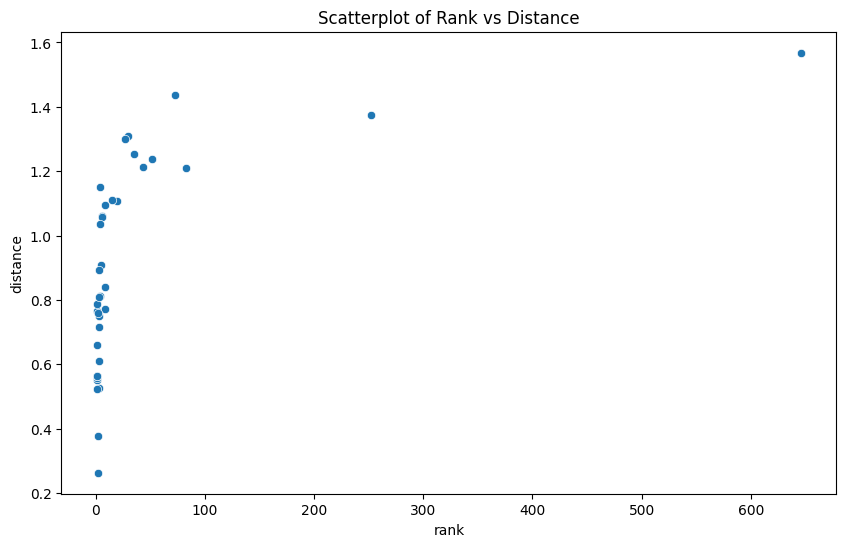

In [170]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='rank', y='distance', data=ens_pairs)
plt.title('Scatterplot Rank vs Distance')
plt.show()

### Time of day

0x76232accd8b6e1827a00462abd9b3cffcad68b9e 15
0xaa68328e0dd8e7ecde1b6c7a01e552c5e33df563 8


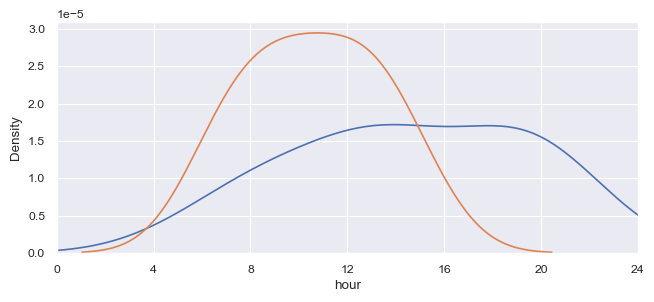

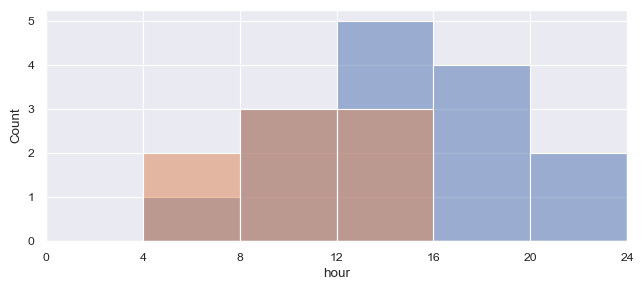

In [47]:
addresses = [idx_map[i] for i in [487, 493]]

show_patterns(all_transfers_df, addresses, hour_bins=6, show_kde=True)

### Find a way to cluster the addresses instead of k nearest neighbors

Do it with different tresholds, see how the number of clusters changes, visualize it

In [16]:
# This will store the clusters. Each cluster is a set of nodes (i.e., a set of indices).
clusters = []

threshold = 0.8

print(embeddings_d2v.shape[0])

# Iterate over all embeddings
for i in range(embeddings_d2v.shape[0]):
    # Query the index for the k nearest neighbors of the i-th embedding
    D, I = faiss_index_d2v.get_dist_idx(i)

    # The indices of the nearest neighbors of the i-th node are in I[0]
    neighbours = set(I[0][D[0] < threshold])

    if not neighbours:
        neighbours = set([i])

    # Check if the node is already part of a cluster
    for cluster in clusters:
        if i in cluster:
            # If the node is part of a cluster, we extend this cluster by the new neighbours
            cluster.update(neighbours)
            break
    else:
        # If the node was not part of any cluster, we create a new cluster
        clusters.append(neighbours)


print(len(clusters))
clusters

51566
36253


[{47489, 48488},
 {0},
 {23863, 26275, 27046, 27571},
 {36886, 36962},
 {4},
 {5},
 {6},
 {548, 551},
 {359, 38896, 38900},
 {9},
 {324, 327, 3100},
 {134, 139},
 {12},
 {19516, 19557},
 {14, 137},
 {15},
 {44, 132},
 {18095, 45561},
 {508, 509},
 {19},
 {20},
 {21, 453},
 {22, 502},
 {23},
 {350, 37410, 37415},
 {25},
 {26},
 {27},
 {38030, 38215},
 {24952, 25733},
 {30},
 {31},
 {32},
 {39787, 39792, 39797},
 {34},
 {12423, 12427},
 {36},
 {12679, 45893, 45894},
 {16132, 42058, 48975},
 {39},
 {39563, 39576},
 {13173, 13191},
 {9098, 9107},
 {30451, 46003},
 {132},
 {9395, 13443, 15691},
 {46},
 {47, 80},
 {48},
 {49},
 {38500, 38515},
 {20015, 47946},
 {52},
 {53},
 {40807, 48240, 48644},
 {55},
 {56},
 {57},
 {9274, 9367},
 {59},
 {60},
 {8329, 33610, 33624},
 {62},
 {63},
 {43074, 43075},
 {50300, 50303, 50305},
 {66},
 {67},
 {68},
 {13295, 45604, 47314},
 {70},
 {71},
 {30242, 30243},
 {21129, 31177, 45141},
 {42394, 45413},
 {75},
 {76},
 {77, 563},
 {1200, 32246, 39441},
 {79,